In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import os
import random
from tqdm import tqdm
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Identity
from transformers import PatchTSTConfig, PatchTSTForClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

D:\Anaconda_3\envs\GPU-pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


In [3]:
# set random seed
def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)

#### import training and testing data

In [4]:
ws = 10
file_train_samples = f'transformer_dataset/train_samples_signature_label4marker_6000_7000_ws{ws}.npy'
file_train_tops = f'transformer_dataset/train_tops_signature_label4marker_6000_7000_ws{ws}.npy'
file_test_samples = f'transformer_dataset/test_samples_label4marker_6000_7000_ws{ws}.npy'
file_test_tops = f'transformer_dataset/test_tops_label4marker_6000_7000_ws{ws}.npy'

In [5]:
samples_train = np.load(file_train_samples)
tops_train = np.load(file_train_tops)
samples_test = np.load(file_test_samples)
tops_test = np.load(file_test_tops)
print(samples_train.shape)
print(samples_test.shape)
print(tops_train.shape)
print(tops_test.shape)

(321, 2000, 3)
(50, 2000, 3)
(321, 3)
(50, 3)


#### prepare dataset and dataloader

In [6]:
# calculate mean and std for train set
# calculate the input padding value 0 after normalization
# define a normlize function
def mean_std(samples):
    gr_values = samples[:,:,1].copy()
    mean = np.mean(gr_values)
    std = np.std(gr_values)
    return mean, std

def normalize(samples):
    gr_values = samples[:,:,1].copy()
    normalized_gr_values = (gr_values - train_mean) / train_std
    samples[:, :, 1] = normalized_gr_values
    return samples

train_mean, train_std = mean_std(samples_train)
input_pad_value = (0 - train_mean) / train_std
print(input_pad_value)

-1.919395492846298


In [7]:
class TSTDataset(Dataset):
    def __init__(self, samples, tops):
        super(TSTDataset, self).__init__()
        self.samples = samples
        self.samples = normalize(self.samples)
    
    def __len__(self):
        return self.samples.shape[0]  
    
    def __getitem__(self, idx):
        depth = self.samples[idx, :, 0]
        x = torch.tensor(self.samples[idx, :, 1])
        y = torch.tensor(self.samples[idx, :, 2])
        
        return depth, x, y

In [8]:
batch_size = 2
train_dataset = TSTDataset(samples_train, tops_train)
test_dataset = TSTDataset(samples_test, tops_test)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)    

#### build the model

In [9]:
# build the patchTST for classification
num_input_channels = 1
patch_length = 128
patch_stride = 1  #use correct stride
num_hidden_layers = 8
num_attention_heads = 8
d_model = 256
num_classes = 5        # three markers + non_marker + padding
bias = False
use_cls_token = False   # 
# padding the input sequence to match output length
desired_length = patch_length - 1
padding_needed = max(0, desired_length)
context_length = samples_train.shape[1] + padding_needed

config = PatchTSTConfig(
    num_input_channels=num_input_channels,
    num_targets=num_classes,
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_stride,
    num_hidden_layers=num_hidden_layers,
    num_attention_heads=num_attention_heads,
    use_cls_token=use_cls_token,
    d_model=d_model,
    bias=bias
)
model = PatchTSTForClassification(config=config).to(device)

# modify the last (head) layer
original_head = model.head

class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
    
model.head = nn.Sequential(
    nn.Linear(in_features=d_model, out_features=num_classes),  
    Lambda(lambda x: x.squeeze(1))  
).to(device)

#### train and validate the model

In [10]:
# set optimizer
learning_rate = 1e-5
adam_epsilon = 1e-8
num_epochs = 15
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
# set the scheduler
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

#set weight for loss function (class_0 is for padding)
class_weights = torch.tensor([0., 0.5 , 1., 1., 1.], dtype=torch.float) 
if torch.cuda.is_available():
    class_weights = class_weights.cuda()
    
criterion = nn.CrossEntropyLoss(weight=class_weights, 
                                ignore_index=0, 
                               label_smoothing=0.0)

In [11]:
# save best test result
best_test_loss =  float('inf')
best_epoch = 0

#train the model and validate
total_train_losses = []
total_test_losses = []

for epoch in range(1, num_epochs+1):
    model.train()
    train_losses = []
    
    pred_list_train = []
    y_list_train = []
    depth_list_train = []
    x_list_train = []    
    #train
    for i, batch in enumerate(tqdm(train_dataloader)):
        depth, x, y = batch
        # pad the input sequence if needed
        if padding_needed > 0:
            padding_before = padding_needed // 2
            padding_after = padding_needed - padding_before
            src = F.pad(x, pad=(padding_before, padding_after), mode='constant', value=input_pad_value) 
        src = src.unsqueeze(-1).to(device).float()
        src_mask = (src != input_pad_value).to(device)
        y = y.to(device).long()

        optimizer.zero_grad()
        outputs = model(past_values = src,
                       past_observed_mask = src_mask)
        preds = outputs.prediction_logits
        preds_reshaped = preds.permute(0,2,1)
        loss = criterion(preds_reshaped, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i % 25 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, num_epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item())) 
        
        # at last epoch, save the prediction result
        #if epoch == num_epochs:
        current_preds = preds.detach().cpu().numpy()
        current_y = y.detach().cpu().numpy()
        current_depth = depth.cpu().numpy()
        current_x = x.detach().cpu().numpy()

        pred_list_train.append(current_preds)
        y_list_train.append(current_y)
        depth_list_train.append(current_depth)
        x_list_train.append(current_x)

    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    scheduler.step()
    
    #validation
    model.eval()
    test_losses = []
    
    pred_list_test = []
    y_list_test = []
    depth_list_test = []
    x_list_test = []   
    for i, batch in enumerate(tqdm(test_dataloader)):
        depth, x, y = batch
        if padding_needed > 0:
            padding_before = padding_needed // 2
            padding_after = padding_needed - padding_before
            src = F.pad(x, pad=(padding_before, padding_after), mode='constant', value=input_pad_value) 
        src = src.unsqueeze(-1).to(device).float()
        src_mask = (src != input_pad_value).to(device)
        y = y.to(device).long()

        with torch.no_grad():
            outputs = model(past_values = src,
                           past_observed_mask = src_mask)
            preds = outputs.prediction_logits
            preds_reshaped = preds.permute(0,2,1)
            loss = criterion(preds_reshaped, y)
        test_losses.append(loss.item())
        
        # at last epoch, save the prediction result
        # if epoch == num_epochs:
        current_preds = preds.detach().cpu().numpy()
        current_y = y.detach().cpu().numpy()
        current_depth = depth.cpu().numpy()
        current_x = x.detach().cpu().numpy()

        pred_list_test.append(current_preds)
        y_list_test.append(current_y)
        depth_list_test.append(current_depth)
        x_list_test.append(current_x)

    test_loss_mean = np.mean(test_losses)
    total_test_losses.append(test_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean)
    print('TEST_LOSS: ', '%.3f' % test_loss_mean)
    print('---------------------------------------------')

    # check if the test loss is the smallest
    #if test_loss_mean <= best_test_loss:
    
    # save the result at last epoch
    if epoch == num_epochs:
        best_test_loss = test_loss_mean
        best_epoch = epoch    
        # update prediction result
        preds_train = np.concatenate(pred_list_train, axis = 0)
        y_train = np.concatenate(y_list_train, axis = 0)
        depth_train = np.concatenate(depth_list_train, axis = 0)
        x_train = np.concatenate(x_list_train, axis = 0)
        preds_test = np.concatenate(pred_list_test, axis = 0)
        y_test = np.concatenate(y_list_test, axis = 0)
        depth_test = np.concatenate(depth_list_test, axis = 0)
        x_test = np.concatenate(x_list_test, axis = 0)

result = [total_train_losses, total_test_losses]
print(f'best test result is obtained at epoch {best_epoch}')

  1%|          | 2/161 [00:05<05:32,  2.09s/it]

Train (epoch 1/15) [0/161 (0%)]	Loss: 1.665571


 17%|█▋        | 27/161 [00:08<00:21,  6.28it/s]

Train (epoch 1/15) [25/161 (16%)]	Loss: 1.191961


 32%|███▏      | 52/161 [00:12<00:17,  6.37it/s]

Train (epoch 1/15) [50/161 (31%)]	Loss: 0.904337


 48%|████▊     | 77/161 [00:16<00:13,  6.24it/s]

Train (epoch 1/15) [75/161 (47%)]	Loss: 0.970043


 63%|██████▎   | 102/161 [00:21<00:09,  5.93it/s]

Train (epoch 1/15) [100/161 (62%)]	Loss: 0.641895


 79%|███████▉  | 127/161 [00:25<00:05,  6.10it/s]

Train (epoch 1/15) [125/161 (78%)]	Loss: 0.766470


 94%|█████████▍| 152/161 [00:29<00:01,  6.01it/s]

Train (epoch 1/15) [150/161 (93%)]	Loss: 0.536517


100%|██████████| 25/25 [00:01<00:00, 21.15it/s]


TRAIN_LOSS:  0.846
TEST_LOSS:  0.403
---------------------------------------------


  1%|          | 1/161 [00:00<00:26,  6.03it/s]

Train (epoch 2/15) [0/161 (0%)]	Loss: 0.519974


 17%|█▋        | 27/161 [00:04<00:22,  6.00it/s]

Train (epoch 2/15) [25/161 (16%)]	Loss: 0.624466


 32%|███▏      | 52/161 [00:08<00:18,  5.96it/s]

Train (epoch 2/15) [50/161 (31%)]	Loss: 0.388039


 48%|████▊     | 77/161 [00:12<00:14,  5.96it/s]

Train (epoch 2/15) [75/161 (47%)]	Loss: 0.248194


 63%|██████▎   | 102/161 [00:17<00:10,  5.87it/s]

Train (epoch 2/15) [100/161 (62%)]	Loss: 0.231335


 79%|███████▉  | 127/161 [00:21<00:05,  5.93it/s]

Train (epoch 2/15) [125/161 (78%)]	Loss: 0.220811


 94%|█████████▍| 152/161 [00:25<00:01,  5.83it/s]

Train (epoch 2/15) [150/161 (93%)]	Loss: 0.203956


100%|██████████| 25/25 [00:01<00:00, 20.80it/s]


TRAIN_LOSS:  0.355
TEST_LOSS:  0.211
---------------------------------------------



  0%|          | 0/161 [00:00<?, ?it/s]

Train (epoch 3/15) [0/161 (0%)]	Loss: 0.315947


 17%|█▋        | 27/161 [00:04<00:23,  5.81it/s]

Train (epoch 3/15) [25/161 (16%)]	Loss: 0.441695


 32%|███▏      | 52/161 [00:08<00:18,  5.84it/s]

Train (epoch 3/15) [50/161 (31%)]	Loss: 0.321150


 48%|████▊     | 77/161 [00:13<00:14,  5.86it/s]

Train (epoch 3/15) [75/161 (47%)]	Loss: 0.267672


 63%|██████▎   | 102/161 [00:17<00:09,  5.93it/s]

Train (epoch 3/15) [100/161 (62%)]	Loss: 0.215206


 79%|███████▉  | 127/161 [00:21<00:05,  5.86it/s]

Train (epoch 3/15) [125/161 (78%)]	Loss: 1.287246


 94%|█████████▍| 152/161 [00:25<00:01,  5.84it/s]

Train (epoch 3/15) [150/161 (93%)]	Loss: 0.229584


100%|██████████| 25/25 [00:01<00:00, 20.88it/s]


TRAIN_LOSS:  0.243
TEST_LOSS:  0.184
---------------------------------------------


  1%|          | 1/161 [00:00<00:26,  5.97it/s]

Train (epoch 4/15) [0/161 (0%)]	Loss: 0.208714


 17%|█▋        | 27/161 [00:04<00:23,  5.80it/s]

Train (epoch 4/15) [25/161 (16%)]	Loss: 0.177771


 32%|███▏      | 52/161 [00:08<00:18,  5.88it/s]

Train (epoch 4/15) [50/161 (31%)]	Loss: 0.145986


 48%|████▊     | 77/161 [00:13<00:14,  5.85it/s]

Train (epoch 4/15) [75/161 (47%)]	Loss: 0.124430


 63%|██████▎   | 102/161 [00:17<00:10,  5.86it/s]

Train (epoch 4/15) [100/161 (62%)]	Loss: 0.165672


 79%|███████▉  | 127/161 [00:21<00:05,  5.81it/s]

Train (epoch 4/15) [125/161 (78%)]	Loss: 0.677282


 94%|█████████▍| 152/161 [00:26<00:01,  5.72it/s]

Train (epoch 4/15) [150/161 (93%)]	Loss: 0.123526


100%|██████████| 25/25 [00:01<00:00, 20.43it/s]


TRAIN_LOSS:  0.199
TEST_LOSS:  0.140
---------------------------------------------


  1%|          | 1/161 [00:00<00:28,  5.58it/s]

Train (epoch 5/15) [0/161 (0%)]	Loss: 0.091989


 17%|█▋        | 27/161 [00:04<00:23,  5.67it/s]

Train (epoch 5/15) [25/161 (16%)]	Loss: 0.143270


 32%|███▏      | 52/161 [00:09<00:19,  5.70it/s]

Train (epoch 5/15) [50/161 (31%)]	Loss: 0.205578


 48%|████▊     | 77/161 [00:13<00:14,  5.63it/s]

Train (epoch 5/15) [75/161 (47%)]	Loss: 0.138347


 63%|██████▎   | 102/161 [00:17<00:10,  5.77it/s]

Train (epoch 5/15) [100/161 (62%)]	Loss: 0.184619


 79%|███████▉  | 127/161 [00:22<00:06,  5.63it/s]

Train (epoch 5/15) [125/161 (78%)]	Loss: 0.083405


 94%|█████████▍| 152/161 [00:26<00:01,  5.72it/s]

Train (epoch 5/15) [150/161 (93%)]	Loss: 0.112023


100%|██████████| 25/25 [00:01<00:00, 20.71it/s]


TRAIN_LOSS:  0.182
TEST_LOSS:  0.134
---------------------------------------------



  0%|          | 0/161 [00:00<?, ?it/s]

Train (epoch 6/15) [0/161 (0%)]	Loss: 0.141233


 17%|█▋        | 27/161 [00:04<00:23,  5.65it/s]

Train (epoch 6/15) [25/161 (16%)]	Loss: 0.122439


 32%|███▏      | 52/161 [00:09<00:19,  5.72it/s]

Train (epoch 6/15) [50/161 (31%)]	Loss: 0.148588


 48%|████▊     | 77/161 [00:13<00:14,  5.81it/s]

Train (epoch 6/15) [75/161 (47%)]	Loss: 0.760752


 63%|██████▎   | 102/161 [00:17<00:10,  5.63it/s]

Train (epoch 6/15) [100/161 (62%)]	Loss: 0.179557


 79%|███████▉  | 127/161 [00:22<00:05,  5.73it/s]

Train (epoch 6/15) [125/161 (78%)]	Loss: 0.128436


 94%|█████████▍| 152/161 [00:26<00:01,  5.70it/s]

Train (epoch 6/15) [150/161 (93%)]	Loss: 0.134394


100%|██████████| 25/25 [00:01<00:00, 20.08it/s]


TRAIN_LOSS:  0.170
TEST_LOSS:  0.129
---------------------------------------------



  0%|          | 0/161 [00:00<?, ?it/s]

Train (epoch 7/15) [0/161 (0%)]	Loss: 0.137784


 17%|█▋        | 27/161 [00:04<00:24,  5.49it/s]

Train (epoch 7/15) [25/161 (16%)]	Loss: 0.089514


 32%|███▏      | 52/161 [00:09<00:19,  5.68it/s]

Train (epoch 7/15) [50/161 (31%)]	Loss: 0.101254


 48%|████▊     | 77/161 [00:13<00:14,  5.64it/s]

Train (epoch 7/15) [75/161 (47%)]	Loss: 0.111948


 63%|██████▎   | 102/161 [00:18<00:10,  5.62it/s]

Train (epoch 7/15) [100/161 (62%)]	Loss: 0.110937


 79%|███████▉  | 127/161 [00:22<00:06,  5.63it/s]

Train (epoch 7/15) [125/161 (78%)]	Loss: 0.110366


 94%|█████████▍| 152/161 [00:27<00:01,  5.55it/s]

Train (epoch 7/15) [150/161 (93%)]	Loss: 0.124679


100%|██████████| 25/25 [00:01<00:00, 19.90it/s]


TRAIN_LOSS:  0.164
TEST_LOSS:  0.140
---------------------------------------------



  0%|          | 0/161 [00:00<?, ?it/s]

Train (epoch 8/15) [0/161 (0%)]	Loss: 0.121139


 17%|█▋        | 27/161 [00:04<00:23,  5.60it/s]

Train (epoch 8/15) [25/161 (16%)]	Loss: 0.118393


 32%|███▏      | 52/161 [00:09<00:19,  5.57it/s]

Train (epoch 8/15) [50/161 (31%)]	Loss: 0.170504


 48%|████▊     | 77/161 [00:13<00:15,  5.49it/s]

Train (epoch 8/15) [75/161 (47%)]	Loss: 0.157199


 63%|██████▎   | 102/161 [00:18<00:10,  5.48it/s]

Train (epoch 8/15) [100/161 (62%)]	Loss: 0.153635


 79%|███████▉  | 127/161 [00:22<00:06,  5.57it/s]

Train (epoch 8/15) [125/161 (78%)]	Loss: 0.142754


 94%|█████████▍| 152/161 [00:27<00:01,  5.61it/s]

Train (epoch 8/15) [150/161 (93%)]	Loss: 0.139200


100%|██████████| 25/25 [00:01<00:00, 19.69it/s]


TRAIN_LOSS:  0.158
TEST_LOSS:  0.124
---------------------------------------------



  0%|          | 0/161 [00:00<?, ?it/s]

Train (epoch 9/15) [0/161 (0%)]	Loss: 0.186220


 17%|█▋        | 27/161 [00:04<00:24,  5.55it/s]

Train (epoch 9/15) [25/161 (16%)]	Loss: 0.189661


 32%|███▏      | 52/161 [00:09<00:19,  5.53it/s]

Train (epoch 9/15) [50/161 (31%)]	Loss: 0.149996


 48%|████▊     | 77/161 [00:13<00:15,  5.50it/s]

Train (epoch 9/15) [75/161 (47%)]	Loss: 0.118011


 63%|██████▎   | 102/161 [00:18<00:10,  5.40it/s]

Train (epoch 9/15) [100/161 (62%)]	Loss: 0.127329


 79%|███████▉  | 127/161 [00:23<00:06,  5.39it/s]

Train (epoch 9/15) [125/161 (78%)]	Loss: 0.165534


 94%|█████████▍| 152/161 [00:27<00:01,  5.42it/s]

Train (epoch 9/15) [150/161 (93%)]	Loss: 0.096310


100%|██████████| 25/25 [00:01<00:00, 19.49it/s]


TRAIN_LOSS:  0.151
TEST_LOSS:  0.122
---------------------------------------------



  0%|          | 0/161 [00:00<?, ?it/s]

Train (epoch 10/15) [0/161 (0%)]	Loss: 0.105703


 17%|█▋        | 27/161 [00:04<00:24,  5.47it/s]

Train (epoch 10/15) [25/161 (16%)]	Loss: 0.115903


 32%|███▏      | 51/161 [00:09<00:20,  5.49it/s]

Train (epoch 10/15) [50/161 (31%)]	Loss: 0.142527


 48%|████▊     | 77/161 [00:13<00:15,  5.52it/s]

Train (epoch 10/15) [75/161 (47%)]	Loss: 0.106488


 63%|██████▎   | 102/161 [00:18<00:10,  5.49it/s]

Train (epoch 10/15) [100/161 (62%)]	Loss: 0.131322


 79%|███████▉  | 127/161 [00:23<00:06,  5.56it/s]

Train (epoch 10/15) [125/161 (78%)]	Loss: 0.118414


 94%|█████████▍| 152/161 [00:27<00:01,  5.43it/s]

Train (epoch 10/15) [150/161 (93%)]	Loss: 0.118888


100%|██████████| 25/25 [00:01<00:00, 19.86it/s]


TRAIN_LOSS:  0.145
TEST_LOSS:  0.127
---------------------------------------------



  0%|          | 0/161 [00:00<?, ?it/s]

Train (epoch 11/15) [0/161 (0%)]	Loss: 0.120026


 17%|█▋        | 27/161 [00:04<00:24,  5.53it/s]

Train (epoch 11/15) [25/161 (16%)]	Loss: 0.096192


 32%|███▏      | 52/161 [00:09<00:19,  5.55it/s]

Train (epoch 11/15) [50/161 (31%)]	Loss: 0.075840


 47%|████▋     | 76/161 [00:13<00:15,  5.52it/s]

Train (epoch 11/15) [75/161 (47%)]	Loss: 0.101978


 63%|██████▎   | 102/161 [00:18<00:10,  5.54it/s]

Train (epoch 11/15) [100/161 (62%)]	Loss: 0.127324


 79%|███████▉  | 127/161 [00:22<00:06,  5.46it/s]

Train (epoch 11/15) [125/161 (78%)]	Loss: 0.085374


 94%|█████████▍| 152/161 [00:27<00:01,  5.38it/s]

Train (epoch 11/15) [150/161 (93%)]	Loss: 0.152484


100%|██████████| 25/25 [00:01<00:00, 19.15it/s]


TRAIN_LOSS:  0.142
TEST_LOSS:  0.154
---------------------------------------------



  0%|          | 0/161 [00:00<?, ?it/s]

Train (epoch 12/15) [0/161 (0%)]	Loss: 0.123331


 17%|█▋        | 27/161 [00:04<00:23,  5.67it/s]

Train (epoch 12/15) [25/161 (16%)]	Loss: 0.095301


 32%|███▏      | 52/161 [00:09<00:19,  5.66it/s]

Train (epoch 12/15) [50/161 (31%)]	Loss: 0.144204


 48%|████▊     | 77/161 [00:13<00:15,  5.51it/s]

Train (epoch 12/15) [75/161 (47%)]	Loss: 0.123404


 63%|██████▎   | 102/161 [00:18<00:10,  5.52it/s]

Train (epoch 12/15) [100/161 (62%)]	Loss: 0.088663


 79%|███████▉  | 127/161 [00:22<00:06,  5.49it/s]

Train (epoch 12/15) [125/161 (78%)]	Loss: 0.116347


 94%|█████████▍| 151/161 [00:27<00:01,  5.38it/s]

Train (epoch 12/15) [150/161 (93%)]	Loss: 0.142293


100%|██████████| 25/25 [00:01<00:00, 18.92it/s]


TRAIN_LOSS:  0.139
TEST_LOSS:  0.125
---------------------------------------------



  0%|          | 0/161 [00:00<?, ?it/s]

Train (epoch 13/15) [0/161 (0%)]	Loss: 0.101157


 17%|█▋        | 27/161 [00:05<00:24,  5.50it/s]

Train (epoch 13/15) [25/161 (16%)]	Loss: 0.132540


 32%|███▏      | 52/161 [00:09<00:20,  5.44it/s]

Train (epoch 13/15) [50/161 (31%)]	Loss: 0.094635


 48%|████▊     | 77/161 [00:14<00:15,  5.35it/s]

Train (epoch 13/15) [75/161 (47%)]	Loss: 0.142760


 63%|██████▎   | 102/161 [00:19<00:11,  5.27it/s]

Train (epoch 13/15) [100/161 (62%)]	Loss: 0.183673


 79%|███████▉  | 127/161 [00:23<00:07,  4.83it/s]

Train (epoch 13/15) [125/161 (78%)]	Loss: 0.084604


 94%|█████████▍| 152/161 [00:28<00:01,  5.73it/s]

Train (epoch 13/15) [150/161 (93%)]	Loss: 0.122457


100%|██████████| 25/25 [00:01<00:00, 18.77it/s]


TRAIN_LOSS:  0.136
TEST_LOSS:  0.127
---------------------------------------------



  0%|          | 0/161 [00:00<?, ?it/s]

Train (epoch 14/15) [0/161 (0%)]	Loss: 0.098055


 17%|█▋        | 27/161 [00:05<00:25,  5.31it/s]

Train (epoch 14/15) [25/161 (16%)]	Loss: 0.118298


 32%|███▏      | 51/161 [00:09<00:22,  4.95it/s]

Train (epoch 14/15) [50/161 (31%)]	Loss: 0.065333


 48%|████▊     | 77/161 [00:14<00:16,  5.16it/s]

Train (epoch 14/15) [75/161 (47%)]	Loss: 0.127803


 63%|██████▎   | 102/161 [00:19<00:11,  5.32it/s]

Train (epoch 14/15) [100/161 (62%)]	Loss: 0.102665


 79%|███████▉  | 127/161 [00:24<00:06,  5.25it/s]

Train (epoch 14/15) [125/161 (78%)]	Loss: 0.139661


 94%|█████████▍| 152/161 [00:28<00:01,  5.30it/s]

Train (epoch 14/15) [150/161 (93%)]	Loss: 0.090757


100%|██████████| 25/25 [00:01<00:00, 18.93it/s]


TRAIN_LOSS:  0.133
TEST_LOSS:  0.111
---------------------------------------------



  0%|          | 0/161 [00:00<?, ?it/s]

Train (epoch 15/15) [0/161 (0%)]	Loss: 0.088221


 17%|█▋        | 27/161 [00:05<00:24,  5.44it/s]

Train (epoch 15/15) [25/161 (16%)]	Loss: 0.070277


 32%|███▏      | 52/161 [00:09<00:20,  5.38it/s]

Train (epoch 15/15) [50/161 (31%)]	Loss: 0.130095


 48%|████▊     | 77/161 [00:14<00:15,  5.38it/s]

Train (epoch 15/15) [75/161 (47%)]	Loss: 0.120799


 63%|██████▎   | 102/161 [00:18<00:10,  5.44it/s]

Train (epoch 15/15) [100/161 (62%)]	Loss: 0.085870


 79%|███████▉  | 127/161 [00:23<00:06,  5.47it/s]

Train (epoch 15/15) [125/161 (78%)]	Loss: 0.078830


 94%|█████████▍| 152/161 [00:28<00:01,  5.46it/s]

Train (epoch 15/15) [150/161 (93%)]	Loss: 0.111070


100%|██████████| 25/25 [00:01<00:00, 19.38it/s]

TRAIN_LOSS:  0.128
TEST_LOSS:  0.130
---------------------------------------------
best test result is obtained at epoch 15


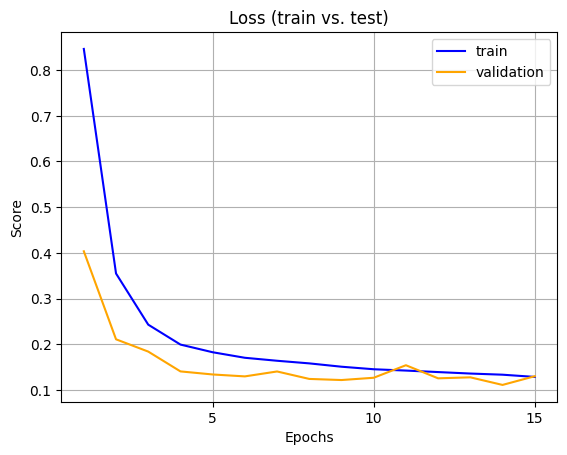

In [12]:
#plot training and validation loss
def plot_graph(train_metric, val_metric, nb_epochs, title):
    x = [int(i) for i in range(1, nb_epochs + 1)]
    plt.plot(x, train_metric, color = 'blue', label = 'train')
    plt.plot(x, val_metric, color = 'orange', label = 'validation')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    x_ticks = [i for i in x if i % 5 == 0]
    plt.title(title)
    plt.xticks(x_ticks)
    plt.grid(True)
    plt.show()

plot_graph(total_train_losses, total_test_losses, num_epochs, 'Loss (train vs. test)')

#### evaluation an visualization

In [13]:
def plot_prediction(sample_preds, sample_x, sample_depth, sample_distribution,
                    pred_locations, true_locations):
    plt.figure(figsize=(15,6))

    # Plotting on the primary y-axis
    # gamma ray
    plt.plot(sample_depth, sample_x * train_std + train_mean, color='black')
    # prediction
    plt.axvline(pred_locations[0], color='red', linestyle = '--', label= 'pred_M')
    plt.axvline(pred_locations[1], color='blue',linestyle = '--', label= 'pred_S')
    plt.axvline(pred_locations[2], color='green', linestyle = '--', label= 'pred_C')
    # ground truth
    plt.axvline(true_locations[0], color='red', label= 'true_M')
    plt.axvline(true_locations[1], color='blue', label= 'true_S')
    plt.axvline(true_locations[2], color='green', label= 'true_C')
    
    plt.xlabel('Depth')
    plt.ylabel('Gamma Ray')
    plt.xticks([i for i in sample_depth if i % 200 == 0])
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)

    # Creating secondary y-axis
    ax2 = plt.gca().twinx()
    # Use the secondary y-axis for the fill_between
    ax2.fill_between(sample_depth, sample_distribution[:,2], color='lightcoral', alpha=0.5, label='Prob_M')
    ax2.fill_between(sample_depth, sample_distribution[:,3], color='lightblue', alpha=0.5, label='Prob_S')
    ax2.fill_between(sample_depth, sample_distribution[:,4], color='lightgreen', alpha=0.5, label='Prob_C')
    ax2.set_ylim(0, 1)  # Setting the range for the secondary y-axis
    ax2.set_ylabel('Probability')

    plt.show()    

In [14]:
def post_process(preds_test, y_test, depth):
    result = []
    for index in range(preds_test.shape[0]):
        # get the sample result without padding
        sample_distribution = np.array(F.softmax(torch.tensor(preds_test[index]), dim = 1))
        sample_preds = np.argmax(sample_distribution, axis=1)
        sample_y = y_test[index]
        sample_depth = depth_test[index]

        mask = sample_y != 0
        sample_distribution = sample_distribution[mask]
        sample_preds = sample_preds[mask]
        sample_depth = sample_depth[mask]
        sample_y = sample_y[mask]
    
        pred_locations = []
        for i in range(2, 5):
            # get the highest probability
            max_value = np.max(sample_distribution[:,i])
            index_loc = np.where(sample_distribution[:,i] == max_value)[0]
            depths = sample_depth[index_loc]
            # take the median as final prediction
            depth = statistics.median(depths)
            pred_locations.append(depth)
        result.append(np.array(pred_locations))
    return result 
    
def combine(sample_distribution, sample_depth, search_range = 1):
    # get dictionary for each marker {location: prob}
    search_dicts = []
    for marker_col in range(2, 5):
        loc_prob_dict = {}
        marker_probs = sample_distribution[:,marker_col]
        sort_prob = np.sort(marker_probs)
        top_probs = sort_prob[-search_range:]
        for i in range(search_range):
            prob_value = top_probs[i]
            index_loc = np.where(marker_probs == prob_value)[0]
            depths = sample_depth[index_loc]
            depth = statistics.median(depths)
            loc_prob_dict[depth] = prob_value
        search_dicts.append(loc_prob_dict)

    # compare all possible combination and give the result
    best_combine_prob = 0
    best_combine = None
    combinations = [(x, y, z) 
                    for x in list(search_dicts[0].keys()) 
                    for y in list(search_dicts[1].keys()) 
                    for z in list(search_dicts[2].keys())]
    for i in range(len(combinations)):
        combination = combinations[i]
        marker_M, marker_S, marker_C = combination[0], combination[1], combination[2]
        diff_1 = marker_S - marker_M
        diff_2 = marker_C - marker_S
        if diff_1 > 0 and diff_2 > 0:
            combine_prob = search_dicts[0][marker_M] * \
                            search_dicts[1][marker_S] * \
                            search_dicts[2][marker_C]
            if combine_prob > best_combine_prob:
                best_combine_prob = combine_prob
                best_combine = combination
    return best_combine

def location_search(preds_test, y_test , depth):
    result = []
    # process for each sample
    for index in range(preds_test.shape[0]):
        sample_distribution = np.array(F.softmax(torch.tensor(preds_test[index]), dim = 1))
        sample_preds = np.argmax(sample_distribution, axis=1)
        sample_depth = depth_test[index]
        sample_y = y_test[index]

        mask = (sample_y != 0)
        sample_distribution = sample_distribution[mask]
        sample_preds = sample_preds[mask]
        sample_depth = sample_depth[mask]  
        sample_y = sample_y[mask]    
        
        search_range = 1
        while True:
            pred_locations = combine(sample_distribution, sample_depth, search_range = search_range)
            search_range += 2
            if pred_locations is not None:
                break
        result.append(np.array(pred_locations)) 
    return result

In [15]:
# evaluate for one tolerance
def evaluate(post_process_result, tops_test, tolerance = 15):
    correct = 0
    total = 0
    for index in range(len(post_process_result)): 
        pred_locations = post_process_result[index]
        true_locations = tops_test[index,:]        
        for i in range(3):
            marker = true_locations[i]
            pred_marker = pred_locations[i]
            total += 1
            if abs(marker - pred_marker) <= tolerance:
                correct += 1
                
    accuracy = correct / total
    print(f'Under tolerance {tolerance}, accuracy: {accuracy}')
    return accuracy

def evaluate_total(post_process_result, tops_test):
    tolerance_list = [5, 10, 15, 20]
    for i in range(len(tolerance_list)):
        acc = evaluate(post_process_result, tops_test, 
                       tolerance = tolerance_list[i])
    
    max_error = 0
    sum_ae = 0
    count = 0
    for index in range(len(post_process_result)): 
        pred_locations = post_process_result[index]
        true_locations = tops_test[index,:]        
        for i in range(3):
            marker = true_locations[i]
            pred_marker = pred_locations[i]
            error = abs(marker - pred_marker)
            max_error = max(max_error, error)
            count += 1
            sum_ae += error
    print(f'100% accuracy tolerance: {max_error}')
    print(f'mean absolute error: {sum_ae / count}')

In [16]:
post_process_result = post_process(preds_test, y_test, depth_test)

In [17]:
print('original post process result:')
evaluate_total(post_process_result, tops_test)

original post process result:
Under tolerance 5, accuracy: 0.6866666666666666
Under tolerance 10, accuracy: 0.9266666666666666
Under tolerance 15, accuracy: 0.9666666666666667
Under tolerance 20, accuracy: 0.9866666666666667
100% accuracy tolerance: 87.0
mean absolute error: 4.8933333333333335


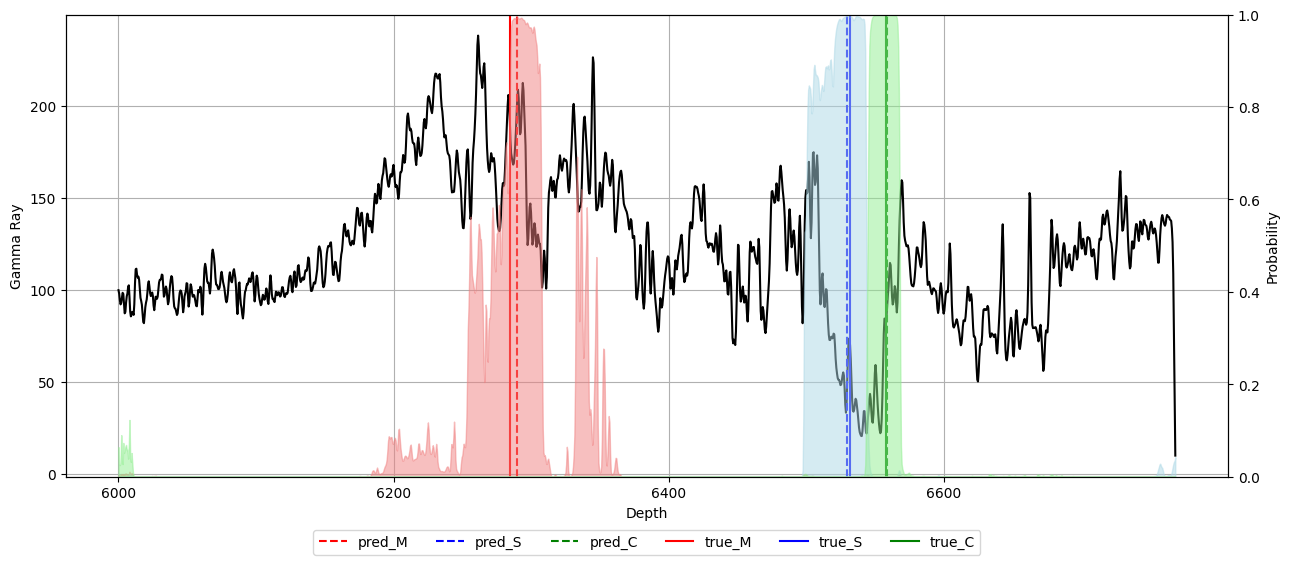

In [18]:
index = 20

sample_distribution = np.array(F.softmax(torch.tensor(preds_test[index]), dim = 1))
sample_preds = np.argmax(sample_distribution, axis=1)
sample_y = y_test[index]
sample_depth = depth_test[index]
sample_x = x_test[index]

mask = sample_y != 0
sample_distribution = sample_distribution[mask]
sample_preds = sample_preds[mask]
sample_depth = sample_depth[mask]
sample_y = sample_y[mask]
sample_x = sample_x[mask]

# get prediction locations
pred_locations = post_process_result[index]
true_locations = tops_test[index,:]

# plot
plot_prediction(sample_preds, sample_x, sample_depth, sample_distribution,
                    pred_locations, true_locations)

In [19]:
location_search_result = location_search(preds_test, y_test, depth_test)

In [20]:
print('location search result:')
evaluate_total(location_search_result, tops_test)

location search result:
Under tolerance 5, accuracy: 0.6866666666666666
Under tolerance 10, accuracy: 0.9266666666666666
Under tolerance 15, accuracy: 0.9666666666666667
Under tolerance 20, accuracy: 0.9866666666666667
100% accuracy tolerance: 87.0
mean absolute error: 4.8933333333333335


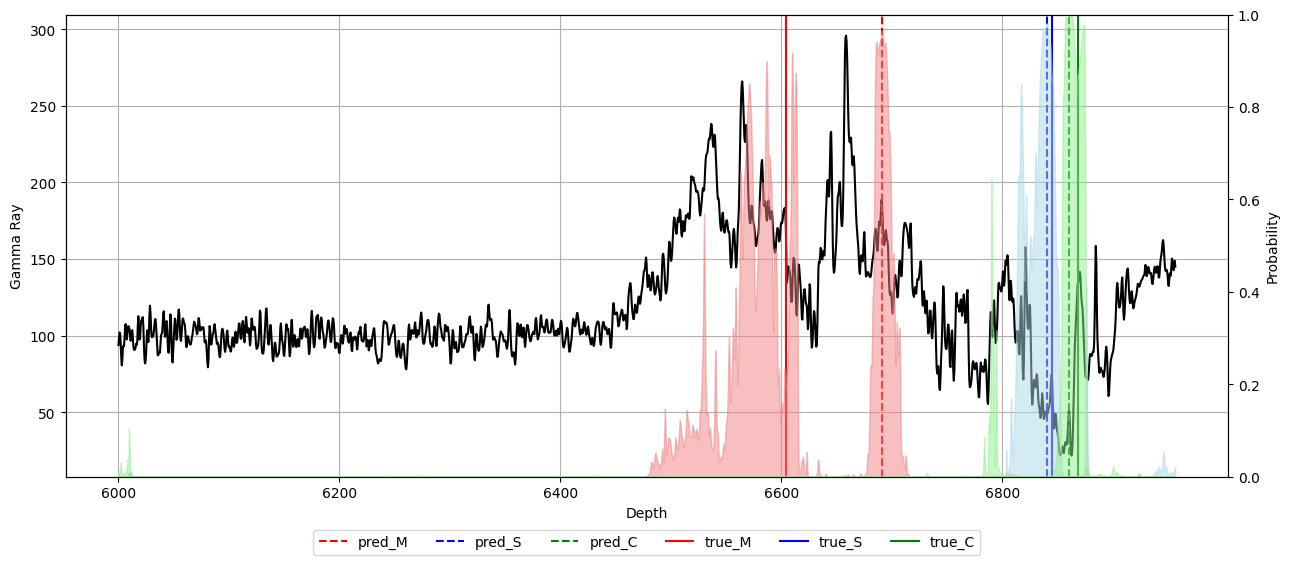

In [21]:
index = 12

sample_distribution = np.array(F.softmax(torch.tensor(preds_test[index]), dim = 1))
sample_preds = np.argmax(sample_distribution, axis=1)
sample_y = y_test[index]
sample_depth = depth_test[index]
sample_x = x_test[index]

mask = sample_y != 0
sample_distribution = sample_distribution[mask]
sample_preds = sample_preds[mask]
sample_depth = sample_depth[mask]
sample_y = sample_y[mask]
sample_x = sample_x[mask]

# get prediction locations
pred_locations = location_search_result[index]
true_locations = tops_test[index,:]

# plot
plot_prediction(sample_preds, sample_x, sample_depth, sample_distribution,
                    pred_locations, true_locations)

#### save and re-evaluate the model

In [22]:
'''
#save the trained model
version = 'V1_acc_98'
model_save_folder = 'transformer_model/PatchTST_label4marker'
model_filename = f'PatchTST_label4marker_{version}.pth'
full_path = os.path.join(model_save_folder, model_filename)

if not os.path.exists(model_save_folder):
    os.makedirs(model_save_folder)

torch.save(model.state_dict(), full_path)
'''

"\n#save the trained model\nversion = 'V1_acc_98'\nmodel_save_folder = 'transformer_model/PatchTST_label4marker'\nmodel_filename = f'PatchTST_label4marker_{version}.pth'\nfull_path = os.path.join(model_save_folder, model_filename)\n\nif not os.path.exists(model_save_folder):\n    os.makedirs(model_save_folder)\n\ntorch.save(model.state_dict(), full_path)\n"